In [9]:
import torch
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

## Create a dummy dataset

In [305]:
# square_size -> (min_size, max_size)

def generate_datapoint(size = (28, 28), square_size = (3, 7)):
    
    assert square_size[0] < size[0] and square_size[0] < size[1]
    assert square_size[1] < size[0] and square_size[1] < size[1]
    
    img = np.zeros(size)
    
    random_square_size = random.randint(*square_size)
    
    x_pos = random.randint(0, size[1] - random_square_size)
    y_pos = random.randint(0, size[0] - random_square_size)
    
    img[x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = 1.0
    
    return img, x_pos, y_pos, random_square_size


def generate_dataset(n = 3000, size = (28, 28), square_size = (3, 7)):
    x = []
    y = []
    
    for _ in range(n):
        img, x_pos, y_pos, spot_size = generate_datapoint(size, square_size)
        x.append(img)
        y.append([x_pos, y_pos, spot_size])
        
    return np.array(x), np.array(y)

In [306]:
X, y = generate_dataset(n = 3000, size = (34, 34), square_size = (3, 7))

In [344]:
X_val, y_val = generate_dataset(n = 512, size = (34, 34), square_size = (3, 7))

## Define Autoencoder Model

In [172]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# import torch
# import torch.nn as nn

# class Autoencoder(nn.Module):
    
#     def __init__(self):
#         super(Autoencoder, self).__init__()
        
#         self.is_log_mode = False
        
#         self.e1 = nn.Sequential(
#             nn.Conv2d(1, 16, 3),
#             nn.BatchNorm2d(16),  # Add BatchNorm2d after Conv2d
#             nn.LeakyReLU(inplace=True),
#             nn.MaxPool2d(2, 2)
#         )
        
#         self.e2 = nn.Sequential(
#             nn.Conv2d(16, 32, 3),
#             nn.BatchNorm2d(32),  # Add BatchNorm2d after Conv2d
#             nn.LeakyReLU(inplace=True),
#             nn.MaxPool2d(2, 2)
#         )
            
#         self.e3 = nn.Sequential(
#             nn.Conv2d(32, 64, 3),
#             nn.BatchNorm2d(64),  # Add BatchNorm2d after Conv2d
#             nn.LeakyReLU(inplace=True)
#         )
            
#         self.e4 = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(5 * 5 * 64, 512),
#             nn.BatchNorm1d(512),  # Add BatchNorm1d after Linear layer
#             nn.LeakyReLU(inplace=True)
#         )
        
#         self.e5 = nn.Sequential(
#             nn.Linear(512, 128),
#             nn.BatchNorm1d(128),  # Add BatchNorm1d after Linear layer
#             nn.LeakyReLU(inplace=True),
#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),  # Add BatchNorm1d after Linear layer
#         )
        
#         self.decoder = nn.Sequential(
#             nn.Linear(64, 128),
#             nn.BatchNorm1d(128),  # Add BatchNorm1d after Linear layer
#             nn.LeakyReLU(inplace=True),

#             nn.Linear(128, 512),
#             nn.BatchNorm1d(512),  # Add BatchNorm1d after Linear layer
#             nn.LeakyReLU(inplace=True),

#             nn.Linear(512, 64 * 5 * 5),
#             nn.ReLU(inplace=True),

#             nn.Unflatten(1, (64, 5, 5)),  # Match the shape after last Conv2d in encoder
            
#             nn.ConvTranspose2d(64, 32, 3),
#             nn.BatchNorm2d(32),  # Add BatchNorm2d after ConvTranspose2d
#             nn.LeakyReLU(inplace=True),
#             nn.Upsample(scale_factor=2, mode='nearest'),  # Reverse MaxPool2d
#             nn.ConvTranspose2d(32, 16, 3),
#             nn.BatchNorm2d(16),  # Add BatchNorm2d after ConvTranspose2d
#             nn.LeakyReLU(inplace=True),
#             nn.Upsample(scale_factor=2, mode='nearest'),
            
#             nn.ConvTranspose2d(16, 1, 3),
#             nn.Sigmoid()
#         )
        
#         self.encoder = [self.e1, self.e2, self.e3, self.e4, self.e5]
        
#     def forward(self, x):
#         for e in self.encoder:
#             x = e(x)
#             if self.is_log_mode:
#                 print(x)
            
#         encoded = x
#         decoded = self.decoder(encoded)
        
#         return decoded, encoded
    
#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
#             elif isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
        
#     def log_mode(self, val):
#         assert type(val) == bool
#         self.is_log_mode = val


### Version 2

In [273]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.is_log_mode = False
        
        self.e1 = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),  # Add BatchNorm2d after Conv2d
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.e2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),  # Add BatchNorm2d after Conv2d
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
            
        self.e3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 512),
            nn.BatchNorm1d(512),  # Add BatchNorm1d after Linear layer
            nn.LeakyReLU(inplace=True)
        )
        
        self.e4 = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),  # Add BatchNorm1d after Linear layer
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 512),
            nn.BatchNorm1d(512),  # Add BatchNorm1d after Linear layer
            nn.LeakyReLU(inplace=True),

            nn.Linear(512, 32 * 7 * 7),
            nn.LeakyReLU(inplace=True),

            nn.Unflatten(1, (32, 7, 7)),  # Match the shape after last Conv2d in encoder
            
            nn.ConvTranspose2d(32, 16, 3),
            nn.BatchNorm2d(16),  # Add BatchNorm2d after ConvTranspose2d
            nn.LeakyReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            
            nn.ConvTranspose2d(16, 1, 3),
            nn.Sigmoid()
        )
        
        self.encoder = [self.e1, self.e2, self.e3, self.e4]
        
    def forward(self, x):
        for e in self.encoder:
            x = e(x)
            if self.is_log_mode:
                print(x)
            
        encoded = x
        decoded = self.decoder(encoded)
        
        return decoded, encoded
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def log_mode(self, val):
        assert type(val) == bool
        self.is_log_mode = val


### Version 3

In [340]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.is_log_mode = False
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),  # Add BatchNorm2d after Conv2d
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(16 * 16 * 16, 256),
            nn.BatchNorm1d(256),  # Add BatchNorm1d after Linear layer
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),  # Add BatchNorm1d after Linear layer
            
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),  # Add BatchNorm1d after Linear layer
            nn.LeakyReLU(inplace=True),

            nn.Linear(256, 16 * 16 * 16),
            nn.LeakyReLU(inplace=True),

            nn.Unflatten(1, (16, 16, 16)),  # Match the shape after last Conv2d in encoder
            
            nn.ConvTranspose2d(16, 1, 3),
            nn.Upsample(scale_factor= 34/18, mode='nearest'),
    
            nn.Sigmoid()
        )
                
    def forward(self, x):
    
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded, encoded
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def log_mode(self, val):
        assert type(val) == bool
        self.is_log_mode = val


In [341]:
ae_model = Autoencoder()

In [342]:
ae_criterion = nn.MSELoss()
ae_optimizer = optim.NAdam(ae_model.parameters(), lr = 1e-5)

## Train AE

In [343]:
batch_size = 32
n_batches = X.shape[0]//batch_size
n_epochs = 100
losses = []

for epoch in range(n_epochs):
    
    for batch_ind in range(0, n_batches):
        
        x = torch.Tensor(X[batch_ind * batch_size: (batch_ind + 1) * batch_size]).unsqueeze(1)
        reconstructed, latent = ae_model(x)
        loss = ae_criterion(reconstructed, x)

        
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        
    losses.append(loss)
    print(f"Loss after {epoch} epochs : {losses[-1].item()}")

Loss after 0 epochs : 0.23170214891433716
Loss after 1 epochs : 0.18010444939136505
Loss after 2 epochs : 0.14154808223247528
Loss after 3 epochs : 0.11221329122781754
Loss after 4 epochs : 0.09004747122526169
Loss after 5 epochs : 0.07359183579683304
Loss after 6 epochs : 0.06146762892603874
Loss after 7 epochs : 0.05249219387769699
Loss after 8 epochs : 0.045764531940221786
Loss after 9 epochs : 0.04062795639038086
Loss after 10 epochs : 0.03665453568100929
Loss after 11 epochs : 0.033482883125543594
Loss after 12 epochs : 0.030888672918081284
Loss after 13 epochs : 0.028710266575217247
Loss after 14 epochs : 0.026849087327718735
Loss after 15 epochs : 0.025223249569535255
Loss after 16 epochs : 0.023786649107933044
Loss after 17 epochs : 0.022501183673739433
Loss after 18 epochs : 0.021335825324058533
Loss after 19 epochs : 0.020270999521017075
Loss after 20 epochs : 0.019292887300252914
Loss after 21 epochs : 0.018389925360679626
Loss after 22 epochs : 0.01755494438111782
Loss afte

In [349]:
ae_model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=4096, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=256, out_feature

In [350]:
_x = torch.Tensor(X[20]).unsqueeze(0).unsqueeze(1)

In [351]:
_x.shape

torch.Size([1, 1, 34, 34])

In [352]:
_recon, latent = ae_model(_x)

In [353]:
ae_criterion(_recon, _x)

tensor(0.0066, grad_fn=<MseLossBackward0>)

In [354]:
img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

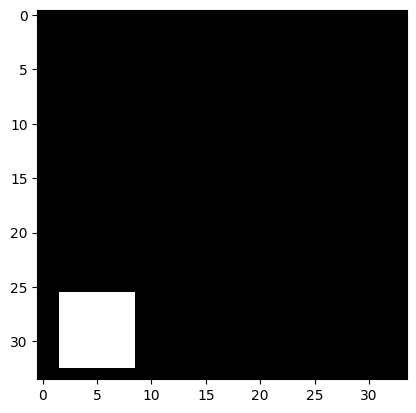

In [355]:
plt.imshow(img, cmap = 'gray')

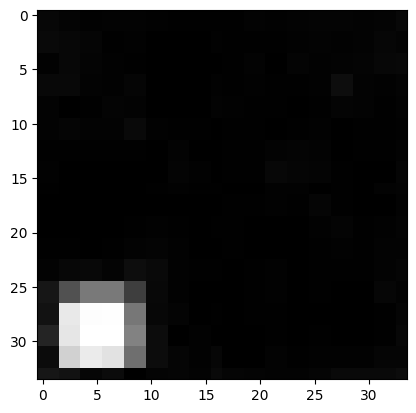

In [356]:
plt.imshow(recon_img, cmap = 'gray')

## Scratch Area

In [153]:
torch.Tensor(X[32:64]).unsqueeze(1).shape

torch.Size([32, 1, 32, 32])

In [198]:
ae_criterion(torch.Tensor(X[0:batch_size]).unsqueeze(1).flatten(), torch.Tensor(X[batch_size:batch_size*2]).unsqueeze(1).flatten())

0.0465235710144043

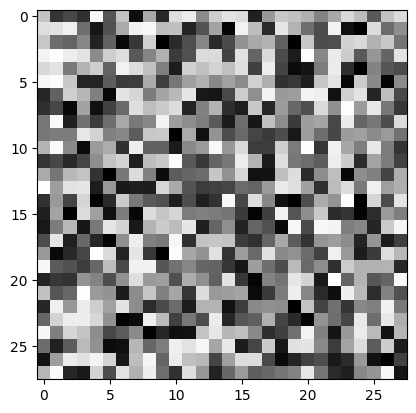

In [85]:
# x = np.ones((28, 28), dtype = np.uint8) * 255
# plt.imshow(x, cmap='gray', vmin=0, vmax=255)


x = np.ones((28, 28)) * np.random.uniform(size = (28, 28)) * 255
plt.imshow(x, cmap = 'gray')